In [0]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load in 

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the "../input/" directory.
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# Any results you write to the current directory are saved as output.

/kaggle/input/quora-insincere-questions-classification/test.csv
/kaggle/input/quora-insincere-questions-classification/train.csv
/kaggle/input/quora-insincere-questions-classification/sample_submission.csv
/kaggle/input/quora-insincere-questions-classification/embeddings/wiki-news-300d-1M/wiki-news-300d-1M.vec
/kaggle/input/quora-insincere-questions-classification/embeddings/glove.840B.300d/glove.840B.300d.txt
/kaggle/input/quora-insincere-questions-classification/embeddings/paragram_300_sl999/paragram_300_sl999.txt
/kaggle/input/quora-insincere-questions-classification/embeddings/paragram_300_sl999/README.txt
/kaggle/input/quora-insincere-questions-classification/embeddings/GoogleNews-vectors-negative300/GoogleNews-vectors-negative300.bin


In [0]:
# dependencies
import os
import json
import string
import numpy as np
import pandas as pd
from pandas.io.json import json_normalize

import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline
from tqdm import tqdm
import math
from sklearn.model_selection import train_test_split
from sklearn import metrics

from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from keras.layers import Dense, Input, LSTM, Embedding, Dropout, Activation, CuDNNGRU, Conv1D
from keras.layers import Bidirectional, GlobalMaxPool1D
from keras.models import Model
from keras import initializers, regularizers, constraints, optimizers, layers


"Quora insincere questions classification" data set consists of questions asked in quora and each question has been labeled as either "0" which is sincere question or "1" an insincere question.<br>


1.   Sincere questions are when the user wants to know an answer genuinely. 
2.   Insincere questions are where the user asks questions based on inflammatory remarks or on false information, etc. 




In [0]:
train_df = pd.read_csv("../input/quora-insincere-questions-classification/train.csv")
test_df = pd.read_csv("../input/quora-insincere-questions-classification/test.csv")
print (train_df.shape)
print (test_df.shape)


(1306122, 3)
(375806, 2)


In [0]:
train_df.head()

,qid,question_text,target
0,00002165364db923c7e6,How did Quebec nationalists see their province as a nation in the 1960s?,0
1,000032939017120e6e44,"Do you have an adopted dog, how would you encourage people to adopt and not shop?",0
2,0000412ca6e4628ce2cf,Why does velocity affect time? Does velocity affect space geometry?,0
3,000042bf85aa498cd78e,How did Otto von Guericke used the Magdeburg hemispheres?,0
4,0000455dfa3e01eae3af,Can I convert montra helicon D to a mountain bike by just changing the tyres?,0


In [0]:
# check for missing data in train_df
train_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1306122 entries, 0 to 1306121
Data columns (total 3 columns):
qid              1306122 non-null object
question_text    1306122 non-null object
target           1306122 non-null int64
dtypes: int64(1), object(2)
memory usage: 29.9+ MB


no missing data

sincere questions = '0' and insincere questions = '1'

In [0]:
pd.set_option('display.max_colwidth', -1)
# lets look at sincere and insincere questions to understand
print (train_df['question_text'][train_df.target==0][:5])
print ('=================')
print (train_df['question_text'][train_df.target==1][:5])

0    How did Quebec nationalists see their province as a nation in the 1960s?         
1    Do you have an adopted dog, how would you encourage people to adopt and not shop?
2    Why does velocity affect time? Does velocity affect space geometry?              
3    How did Otto von Guericke used the Magdeburg hemispheres?                        
4    Can I convert montra helicon D to a mountain bike by just changing the tyres?    
Name: question_text, dtype: object
22     Has the United States become the largest dictatorship in the world?                                                                      
30     Which babies are more sweeter to their parents? Dark skin babies or light skin babies?                                                   
110    If blacks support school choice and mandatory sentencing for criminals why don't they vote Republican?                                   
114    I am gay boy and I love my cousin (boy). He is sexy, but I dont know what to do. He is h

In [0]:
# number of sincere and insincere questions
train_df.target.value_counts()

0    1225312
1    80810  
Name: target, dtype: int64

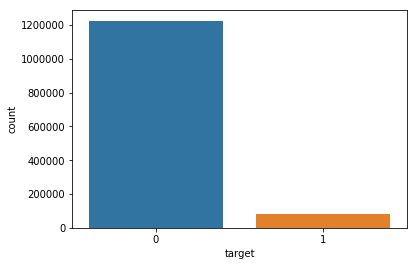

In [0]:
# data visualization
sns.countplot(train_df.target)

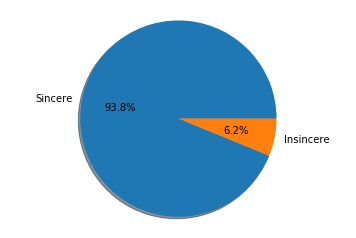

In [0]:
# pie chart
labels = ['Sincere','Insincere']
values = [train_df.target.value_counts()[0], train_df.target.value_counts()[1]]
fig1, ax1 = plt.subplots()
ax1.pie(values , labels = labels, autopct = '%1.1f%%', shadow = True)
ax1.axis('equal')
plt.show()

In [0]:
# word clouds to see which words in 'sincere' and 'insincere' questions are more frequent
from wordcloud import WordCloud, STOPWORDS

In [0]:
stopwords = set(STOPWORDS)

def show_wordcloud(data, title = None):
    wordcloud = WordCloud(background_color = 'black',
                         stopwords = stopwords,
                         max_words = 500,
                         max_font_size = 50,
                         scale = 3,
                         random_state = 1).generate(str(data))
    
    fig = plt.figure(1, figsize = (15,15))
    plt.axis('off')
    if title:
        fig.suptitle(title, fontsize = 20)
        fig.subplots_adjust(top = 2.3)
    
    plt.imshow(wordcloud)
    plt.show()

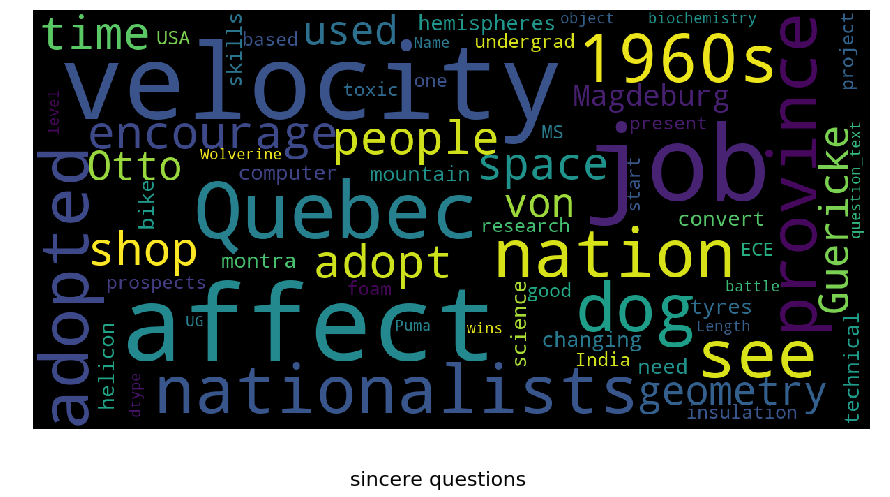

In [0]:
show_wordcloud(train_df['question_text'][train_df.target == 0], title = "sincere questions")

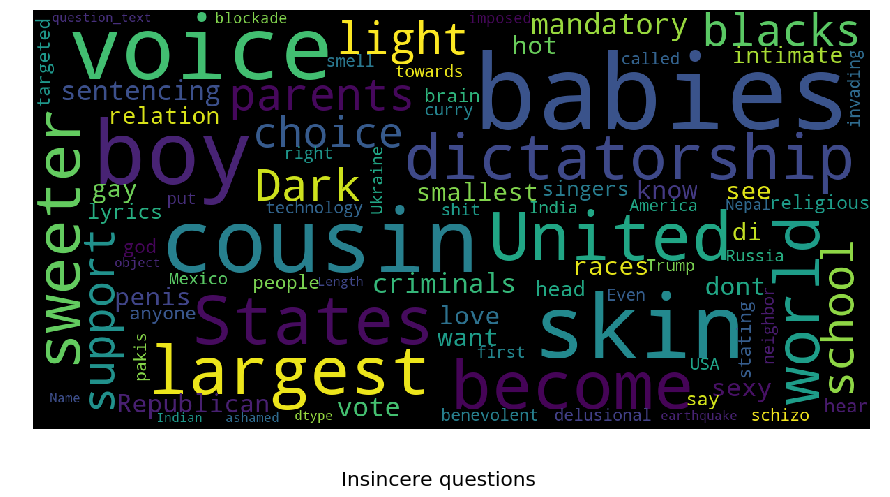

In [0]:
show_wordcloud(train_df['question_text'][train_df.target == 1], title = "Insincere questions")

In [0]:
# train_test split
train, val = train_test_split(train_df, test_size = 0.1 , random_state = 42)

emb_size = 300
max_features = 50000
maxlen = 100

train_x = train['question_text']
val_x = val['question_text']



In [0]:
# tokenize the sentences
tokenizer = Tokenizer(num_words = max_features)
tokenizer.fit_on_texts(list(train_x))
train_x = tokenizer.texts_to_sequences(train_x)
val_x = tokenizer.texts_to_sequences(val_x)

In [0]:
# pad sentences to max length
train_x = pad_sequences(train_x, maxlen = maxlen)
val_x = pad_sequences(val_x, maxlen = maxlen)

In [0]:
train_y = train.target.values
val_y = val.target.values

In [0]:
# Bidirentional GRU model
input = Input(shape = (maxlen,))
x = Embedding(max_features , emb_size)(input)
x = Bidirectional(CuDNNGRU(64, return_sequences = True))(x)
x = GlobalMaxPool1D()(x)
x = Dense(16, activation = 'relu')(x)
x = Dropout(0.1)(x)
x = Dense(1, activation = 'sigmoid')(x)

model = Model(inputs = input , outputs = x)

model.compile(loss = 'binary_crossentropy', optimizer = 'adam', metrics = ['accuracy'])

print(model.summary())

Model: "model_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         (None, 100)               0         
_________________________________________________________________
embedding_2 (Embedding)      (None, 100, 300)          15000000  
_________________________________________________________________
bidirectional_2 (Bidirection (None, 100, 128)          140544    
_________________________________________________________________
global_max_pooling1d_2 (Glob (None, 128)               0         
_________________________________________________________________
dense_3 (Dense)              (None, 16)                2064      
_________________________________________________________________
dropout_2 (Dropout)          (None, 16)                0         
_________________________________________________________________
dense_4 (Dense)              (None, 1)                 17  

In [0]:
# training the model
model.fit(train_x, train_y , batch_size = 512 , epochs = 2, validation_data = (val_x, val_y))

Train on 1175509 samples, validate on 130613 samples
Epoch 1/2
1175509/1175509 [==============================] - 93s 79us/step - loss: 0.1233 - accuracy: 0.9531 - val_loss: 0.1041 - val_accuracy: 0.9585
Epoch 2/2
1175509/1175509 [==============================] - 93s 79us/step - loss: 0.0986 - accuracy: 0.9605 - val_loss: 0.1031 - val_accuracy: 0.9592


In [0]:
 test_x = test_df.question_text

In [0]:
token_test = tokenizer.texts_to_sequences(test_x)
token_test = pad_sequences(token_test , maxlen = maxlen)
pred_y = model.predict([token_test] , batch_size = 512 , verbose = 1)

375806/375806 [==============================] - 8s 22us/step


In [0]:
y_te = (pred_y[:,0] > 0.5).astype(np.int)

In [0]:
pd.DataFrame(y_te)[0].value_counts()

0    358092
1    17714 
Name: 0, dtype: int64

In [0]:
pred_test_df = pd.DataFrame({"qid": test_df.qid , "question_text": test_df.question_text,"prediction":y_te})


In [0]:
pred_test_df.head()

,qid,question_text,prediction
0,0000163e3ea7c7a74cd7,Why do so many women become so rude and arrogant when they get just a little bit of wealth and power?,1
1,00002bd4fb5d505b9161,When should I apply for RV college of engineering and BMS college of engineering? Should I wait for the COMEDK result or am I supposed to apply before the result?,0
2,00007756b4a147d2b0b3,What is it really like to be a nurse practitioner?,0
3,000086e4b7e1c7146103,Who are entrepreneurs?,0
4,0000c4c3fbe8785a3090,Is education really making good people nowadays?,0


In [0]:
pred_test_df[pred_test_df.prediction == 1][:5]

,qid,question_text,prediction
0,0000163e3ea7c7a74cd7,Why do so many women become so rude and arrogant when they get just a little bit of wealth and power?,1
17,00025f4a23df8d58e6ff,Can we eat human poop?,1
21,000383e4ebd22f6ede04,"Why do so many people on this damn site not actually answer the question, but give some stupid and probably fake anecdotes instead?",1
27,00046c9db89b3d758708,"Let's say that hypothetically the alt-right nightmare comes true, and Muslims take over the west and start a new Islamic Empire. Christians and other religious minorities mount a rebellion, but what do atheists do?",1
42,00077e9f6f1069806a96,Why most Telugu and Marathi Muslims speak Urdu and are ashamed of their native languages?,1


if we take a look at a sample of questions that were predicted as "Insincere" we can say that the model is doing good . i mean these questions reflect hatered against gender, race, religion and stereotyping 

In [0]:
pred_test_df[pred_test_df.prediction == 0][:5]

,qid,question_text,prediction
1,00002bd4fb5d505b9161,When should I apply for RV college of engineering and BMS college of engineering? Should I wait for the COMEDK result or am I supposed to apply before the result?,0
2,00007756b4a147d2b0b3,What is it really like to be a nurse practitioner?,0
3,000086e4b7e1c7146103,Who are entrepreneurs?,0
4,0000c4c3fbe8785a3090,Is education really making good people nowadays?,0
5,000101884c19f3515c1a,How do you train a pigeon to send messages?,0


if we take a look at a sample of questions that were predicted as "Sincere" we can say that the model is doing good too . In these questions the user genuinely wants to know the answers .